In [93]:
import pyprind
import pandas as pd
import os
import numpy as np
import re
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Extract the aclImdb_v1.tar.gz and you can acquire file 'aclImdb'.
# Put file 'aclImdb' in the same location with this ipynb.

# Data Processing

basepath = 'aclImdb'

labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], ignore_index=True)
            pbar.update()
df.columns = ['review', 'sentiment']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:19


In [94]:
# Shuffle all the data, including the training data and testing data

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
df.to_csv('movie_data.csv', index=False, encoding='utf-8')

In [95]:
# Define the tool function that will be used in the SGDClassification Process

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text.lower())
    text = re.sub('[\W]+', ' ', text.lower())  + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized
def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
        next(csv) # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

In [96]:
# Use Hash to form the doc stream. Also let the number of features be 2**21

vect = HashingVectorizer(decode_error='ignore',
                         n_features=2**21,
                         preprocessor=None,
                         tokenizer=tokenizer)
clf = SGDClassifier(loss='log', random_state=1)
doc_stream = stream_docs(path='movie_data.csv')

In [97]:
# Use first 25000 data to run the SGDClassification Process. Minibatch size is 1000
# And then use the left 25000 testing data to calculate the accurary

ACC = []
pbar = pyprind.ProgBar(25)
classes = np.array([0, 1])
for _ in range(25):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    ACC.append(clf.score(X_test,y_test))
    pbar.update()
    
X_test, y_test = get_minibatch(doc_stream, size=25000)
X_test = vect.transform(X_test)
print('Accuracy: %.3f' % clf.score(X_test, y_test))

0% [#########################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


Accuracy: 0.871


In [98]:
# Show the prediction result

clf_y_predict=clf.predict(X_test)
print(classification_report(y_test,clf_y_predict,target_names=['Positive','Negative']))

              precision    recall  f1-score   support

    Positive       0.88      0.86      0.87     12527
    Negative       0.86      0.88      0.87     12473

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



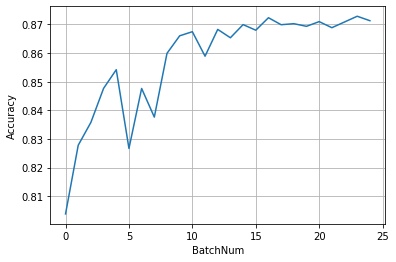

In [99]:
# Show the improvement of accuracy in the training process

x = range(25)
plt.plot(x, ACC)
plt.xlabel('BatchNum')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [100]:
# Use the 25000 testing data to update the model weights and show the model parameters

clf = clf.partial_fit(X_test, y_test)
clf.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'log',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [101]:
# Show the weights of the final model that are not equal to 0

[w for w in clf.coef_[0] if w != 0]

[0.02342744425072423,
 -0.021277791920242484,
 -0.01947930704412387,
 -0.002834845650754748,
 0.006876235120533404,
 -0.022439922109058628,
 -0.0030348658681447374,
 -0.0461547092387263,
 0.004841792304312684,
 -0.003575164876806775,
 -0.0047730008843789385,
 0.003235637271433554,
 0.005307756743661712,
 -0.007371546102807925,
 0.07979300328408355,
 -0.009115549215427015,
 1.5101846920866198,
 -0.006881848673940749,
 -0.0015825099670117562,
 0.00074463079292359,
 -0.007986171619508481,
 0.07611729991799351,
 -0.003821532814926605,
 -0.039407737699401285,
 0.002848844953735566,
 0.002683988689230225,
 -0.3385841599469352,
 -0.004932947719387834,
 -0.0018651078169567529,
 -0.0006468021540663253,
 -0.0035272093544720124,
 -0.0005692904186722754,
 0.008423694460682944,
 0.0016515135644904755,
 -0.0034543285512947898,
 0.604074592039182,
 0.010481522799555243,
 -0.003593617514968276,
 0.034023693682524066,
 -0.1681619765384316,
 0.01730246806838916,
 0.01390649010702971,
 0.0399409721991364